In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import intake,yaml
import intake_esm
from scipy import special
import keras
from keras.models import Model
from keras.layers import Dense, Input

from netCDF4 import Dataset
import scipy as sp
import scipy.io as sp_io
from mpl_toolkits.basemap import Basemap, cm, shiftgrid
import seaborn as sns
from matplotlib.colors import ListedColormap
colours=sns.color_palette('colorblind', 10)
my_cmap = ListedColormap(colours)

In [2]:
#%pip install git+https://github.com/jbusecke/cmip6_preprocessing.git

In [3]:
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.preprocessing import (correct_units,rename_cmip6)

In [4]:
def pp_enso(ds):
    ds = ds.copy()   #the wrapper function makes a copy of the ds and works from this
    ds = rename_cmip6(ds)
    #ds = fix_time(ds)
    #ds = fix_units(ds)
    #ds = correct_units(ds)
    return ds

## Retrieving CNRM-ESM2-1 data

for the other models and scenarios, please change the variable "expname_filter" and "model_filter"

In [5]:
col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
col = intake.open_esm_datastore(col_url)
esmcol_data = col.esmcol_data

In [7]:
%pwd

'/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CNRM-ESM2-1'

In [8]:
def latest_version(cat):#this function gets the latest version of our catalog
    """
    input
    cat: esmdatastore
    output
    esmdatastore with latest DRS versions
    """
    latest_cat = cat.df.sort_values(by=['version','path']).drop_duplicates(['temporal subset','model','mip_table',
                                               'institute','variable','ensemble_member',
                                               'grid_label','experiment_id'],keep='last')
    return latest_cat


In [9]:
#define location of weights file and image output here
import sys,os
wgtsdir = "/home/jovyan/DNN4Cli/ensembleMLP"
imgdirHisto = "png_historical_CNRM-ESM2-1"
imgdir1prct = "png_1prctCO2_CNRM-ESM2-1"
imgdirabrupt4Co2 = "png_abrupt4prctCO2_CNRM-ESM2-1"
if(os.path.exists(wgtsdir)):
    print("weight dir exists")
else:
    sys.exit("weights directory is invalid")
if(os.path.exists(wgtsdir+'/vanillamodel_0.h5')):
    print("weight file exists")
else:
    sys.exit("weights directory is invalid:"+wgtsdir+'/vanillamodel_0.h5')   
    
if not os.path.exists(imgdirHisto):
    os.makedirs(imgdirHisto)
if not os.path.exists(imgdir1prct):
    os.makedirs(imgdir1prct)
if not os.path.exists(imgdirabrupt4Co2):
    os.makedirs(imgdirabrupt4Co2)

weight dir exists
weight file exists


## A query for all data Needed to run all the variable and experiment under CNRM-ESM2-1

In [136]:
query_Omon_tauuo = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 mip_table=['Omon'],
                 ensemble_member=["r1i1p1f1","r1i1p1f2"],
                 model=['CNRM-ESM2-1'],
                 grid_label=['gn'],
                 variable=["tauuo"])
query_Omon_tauvo = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 mip_table=['Omon'],
                 ensemble_member=["r1i1p1f1","r1i1p1f2"],
                 model=['CNRM-ESM2-1'],
                 grid_label=['gn'],
                 variable=["tauvo"])
query_Omon_zos = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 mip_table=['Omon'],
                 ensemble_member=["r1i1p1f1","r1i1p1f2"],
                 model=['CNRM-ESM2-1'],
                 grid_label=['gn'],
                 variable=["zos"])
query_Ofx = dict(experiment_id=['1pctCO2','abrupt-4xCO2','historical'],
                 mip_table=['Ofx'],
                 ensemble_member=["r1i1p1f1","r1i1p1f2"],
                 model=['CNRM-ESM2-1'],
                 grid_label=['gn'],
                 variable=["deptho"])

In [137]:
cat_Ofx = col.search(**query_Ofx) 
cat_Omon_tauuo_lat = latest_version(cat_Ofx)

In [138]:
cat_Omon_tauuo_lat

,project,institute,model,experiment_id,frequency,modeling_realm,mip_table,ensemble_member,grid_label,variable,temporal subset,version,path
0,CMIP6,CNRM-CERFACS,CNRM-ESM2-1,1pctCO2,NaN,NaN,Ofx,r1i1p1f2,gn,deptho,NaN,v20181018,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-E...
1,CMIP6,CNRM-CERFACS,CNRM-ESM2-1,abrupt-4xCO2,NaN,NaN,Ofx,r1i1p1f2,gn,deptho,NaN,v20181026,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-E...


In [139]:
cat_Ofx_latest = intake.open_esm_datastore(cat_Omon_tauuo_lat,esmcol_data=esmcol_data)

In [140]:
cat_Ofx_latest

,unique
project,1
institute,1
model,1
experiment_id,2
frequency,0
modeling_realm,0
mip_table,1
ensemble_member,1
grid_label,1
variable,1


In [141]:
set_dict_Ofx= cat_Ofx_latest.to_dataset_dict(storage_options={'anon':True},preprocess = pp_enso)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [143]:
set_dict_Ofx.keys()

dict_keys(['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Ofx', 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.1pctCO2.Ofx'])

In [145]:
xr_Ofx_abrupt4pctCO2 = set_dict_Ofx['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Ofx']
xr_Ofx_abrupt4pctCO2.deptho.shape

(1, 75, 294, 362)

In [146]:
xr_Ofx_abrupt4pctCO2

<xarray.Dataset>
Dimensions:          (bnds: 2, ensemble_member: 1, lev: 75, vertex: 4, x: 362, y: 294)
Coordinates:
    lat              (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon              (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * lev              (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f2'
Dimensions without coordinates: bnds, vertex, x, y
Data variables:
    lon_bounds       (y, x, vertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat_bounds       (y, x, vertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lev_bounds       (lev, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    deptho           (ensemble_member, lev, y, x) float32 dask.array<chunksize=(1, 75, 294, 362), meta=np.ndarray>
Attributes: (12/54)
    name:                    /scratch/utmp/ftdir/seferian/eclis/transfers/CNR...
    Conventions:             CF-1.7 CMIP-6.2
    creation_date:           2018-07-11T11:45:31Z
    tracking_id:             hdl:21.14100/480fe52e-0fef-4f6d-84b6-29d653113eb0
    description:             DECK: abrupt-4xCO2
    title:                   CNRM-ESM2-1 model output prepared for CMIP6 / CM...
    ...                      ...
    dr2xml_md5sum:           789c0010d555326fb79e73c3e20c5d0e
    xios_commit:             1442-shuffle
    nemo_gelato_commit:      49095b3accd5d4c_6524fe19b00467a
    arpege_minor_version:    6.3.2
    intake_esm_varname:      ['deptho']
    intake_esm_dataset_key:  CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Ofx

## Saving Ofx as a an npz file

In [147]:
lat = xr_Ofx_abrupt4pctCO2.lat
lat.shape

(294, 362)

In [148]:
lon = xr_Ofx_abrupt4pctCO2.lon

In [149]:
deptho = xr_Ofx_abrupt4pctCO2.deptho

In [150]:
np.savez("CNRM-ESM2-1_Ofx_lat_lon_deptho.npz", lat =lat ,lon= lon, deptho = deptho)

## Continuation with other variables zos, tauuo, and tauvo

In [151]:
cat_Omon_tauuo = col.search(**query_Omon_tauuo)
cat_Omon_tauuo_lat = latest_version(cat_Omon_tauuo)

cat_Omon_tauvo = col.search(**query_Omon_tauvo)
cat_Omon_tauvo_lat = latest_version(cat_Omon_tauvo)

cat_Omon_zos = col.search(**query_Omon_zos)
cat_Omon_zos_lat = latest_version(cat_Omon_zos)


In [152]:

cat_Omon_tauuo_latest = intake.open_esm_datastore(cat_Omon_tauuo_lat,esmcol_data=esmcol_data)
cat_Omon_tauvo_latest = intake.open_esm_datastore(cat_Omon_tauvo_lat,esmcol_data=esmcol_data)
cat_Omon_zos_latest = intake.open_esm_datastore(cat_Omon_zos_lat,esmcol_data=esmcol_data)


## Converting the catalogs into xarray datasets

In [153]:
set_dict_zos = cat_Omon_zos_latest.to_dataset_dict(cdf_kwargs={'decode_times': True,'use_cftime': True,'chunks': {'time': 20}}, storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [154]:
set_dict_tauuo = cat_Omon_tauuo_latest.to_dataset_dict(cdf_kwargs={'decode_times': True,'use_cftime': True,'chunks': {'time': 20}}, storage_options={'anon':True})
set_dict_tauvo = cat_Omon_tauvo_latest.to_dataset_dict(cdf_kwargs={'decode_times': True,'use_cftime': True,'chunks': {'time': 20}}, storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [155]:
list(set_dict_zos.keys())

['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon',
 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.1pctCO2.Omon',
 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Omon']

In [156]:
list(set_dict_tauuo.keys())

['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon',
 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.1pctCO2.Omon',
 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Omon']

In [157]:
list(set_dict_tauvo.keys())

['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon',
 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.1pctCO2.Omon',
 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Omon']

## CNRM-ESM2-1 Historical Data for zos,tauuo, and tauvo

In [158]:
xr_zos_Histo = set_dict_zos['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon']
xr_tauuo_Histo = set_dict_tauuo['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon']
xr_tauvo_Histo = set_dict_tauvo['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon']



In [172]:
xr_tauvo_Histo.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
2014-08-16 12:00:00,2014-08-16 12:00:00
2014-09-16 00:00:00,2014-09-16 00:00:00
2014-10-16 12:00:00,2014-10-16 12:00:00


## CNRM-ESM2-1 1%tCO2 Data for zos,tauuo, and tauvo

In [164]:
xr_zos_1prctCO2 = set_dict_zos['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.1pctCO2.Omon']
xr_tauuo_1prctCO2 = set_dict_tauuo['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.1pctCO2.Omon']
xr_tauvo_1prctCO2 = set_dict_tauvo['CMIP6.CNRM-CERFACS.CNRM-ESM2-1.1pctCO2.Omon']

In [174]:
xr_tauvo_1prctCO2.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
1999-08-16 12:00:00,1999-08-16 12:00:00
1999-09-16 00:00:00,1999-09-16 00:00:00
1999-10-16 12:00:00,1999-10-16 12:00:00


## CNRM-ESM2-1 abrupt-4xCO2 Data for zos,tauuo, and tauvo

In [167]:
xr_zos_abrupt4prctCO2 = set_dict_zos[ 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Omon']
xr_tauuo_abrupt4prctCO2 = set_dict_tauuo[ 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Omon']
xr_tauvo_abrupt4prctCO2 = set_dict_tauvo[ 'CMIP6.CNRM-CERFACS.CNRM-ESM2-1.abrupt-4xCO2.Omon']

In [176]:
xr_zos_abrupt4prctCO2.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
1999-08-16 12:00:00,1999-08-16 12:00:00
1999-09-16 00:00:00,1999-09-16 00:00:00
1999-10-16 12:00:00,1999-10-16 12:00:00


## Running CNRM-ESM2-1 Historical

## Making some plots

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


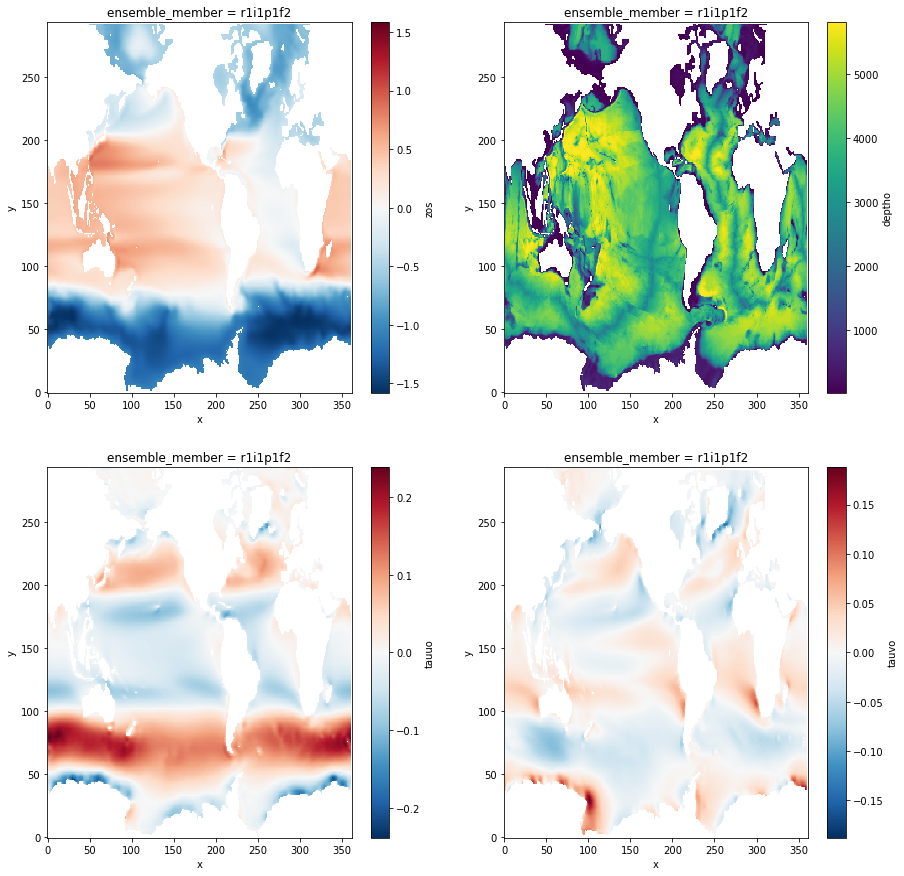

In [178]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
xr_zos_Histo.zos.sel(time=slice("1992", "2011")).mean(axis=1).plot()

plt.subplot(2,2,2)
xr_Ofx_abrupt4pctCO2.deptho[0,:,:,:].max(axis=0).plot()

plt.subplot(2,2,3)
xr_tauuo_Histo.tauuo.sel(time=slice("1992", "2011")).mean(axis=1).plot()

plt.subplot(2,2,4)
xr_tauvo_Histo.tauvo.sel(time=slice("1992", "2011")).mean(axis=1).plot()

### Preparing the features for the EnsembleMLP

In [180]:
def grad(d,y,x):
    "Returns a three point derivative."
    g0, g1 = np.gradient(d)
    grady=g0/y
    gradx=g1/x
    return grady, gradx

In [183]:
Ofx = xr_Ofx_abrupt4pctCO2.deptho[0,:,:,:].max(axis=0)###This is specific to CES
####
lonRoll = np.roll(Ofx.lon.values, axis=1, shift=-1)
Londiff = lonRoll - Ofx.lon.values
latDiff=1.111774765625000e+05
latY=np.gradient(Ofx.lat.values, axis=0)*latDiff
lonX=np.abs(np.cos(Ofx.lat.values*np.pi/180))*latDiff*Londiff
####
Omega=7.2921e-5
f=(2*Omega*np.sin(Ofx.lat.values*np.pi/180))

In [185]:
from pickle import load
#######!!!!!! it might ask you to use scikit-learn 0.22.2.post1 !!!!!! check if you get the good .mean_ and .scale_
#(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
#         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
# array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
#        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))
scaler = load(open('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/scaler_v1.pkl', 'rb'))

In [186]:
scaler.mean_, scaler.scale_

(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
 array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))

In [187]:
from matplotlib.colors import ListedColormap
mycmap = ListedColormap(['royalblue', 'cyan','yellow', 'orange', 'magenta', 'red'])

In [190]:
ecco_label = np.load('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/eccolabel.npy')

In [191]:
listyears = ["1872","1891","1892","1911","1912","1931","1932","1951","1952","1971","1972","1991","1992","2011"]

## Predictions ... CNRM-ESM2-1 Historical

In [192]:
datapredicted_results_Histo = np.nan * np.zeros((7,)+Ofx.shape)

for i in range(7):
    
    print(listyears[2*i]+listyears[2*i+1])
    SSH20Mean = xr_zos_Histo.zos.isel(ensemble_member=0).sel(time=slice(listyears[2*i], listyears[2*i+1])).mean(axis=0).values
    TauUOMean = xr_tauuo_Histo.tauuo.isel(ensemble_member=0).sel(time=slice(listyears[2*i], listyears[2*i+1])).mean(axis=0).values
    TauVOMean = xr_tauvo_Histo.tauvo.isel(ensemble_member=0).sel(time=slice(listyears[2*i], listyears[2*i+1])).mean(axis=0).values

    ####
    print('Calculate grads')
    gradSSH_y, gradSSH_x = grad(SSH20Mean,latY,lonX)
    gradOfx_y, gradOfx_x = grad(Ofx,latY,lonX)
    gradUx_y, gradUx_x = grad(TauUOMean,latY,lonX)
    gradUy_y, gradUy_x = grad(TauVOMean,latY,lonX)
    ####
    print('Calculate CurlTau')
    curlTau =(gradUy_x-gradUx_y)/1032
    
    ####
    print('Calculate missindx')
    missingdataindex = np.isnan(curlTau*SSH20Mean*
                                   gradSSH_x*gradSSH_y*
                                   Ofx*gradOfx_x*
                                   gradOfx_y*f)
    ####
    print('Creating TotalDataset')
    TotalDataset = np.stack((curlTau[~missingdataindex],
                         SSH20Mean[~missingdataindex],
                         gradSSH_x[~missingdataindex],
                         gradSSH_y[~missingdataindex],
                         Ofx.values[~missingdataindex],
                         gradOfx_x[~missingdataindex],
                         gradOfx_y[~missingdataindex],
                         f[~missingdataindex]),1)
    ####
    print('NN pred')
    
    datapredicted_results_vanilla_ensemble = np.nan * np.zeros((50,TotalDataset.shape[0],6))

    for j in range(50):
        I1 = Input(shape=(8,)) 
        h1 = Dense(24, activation='tanh')(I1)
        h1 = Dense(24, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        Output = Dense(6, activation='softmax')(h1)
        vanillamodel = Model(I1, Output)
        vanillamodel.load_weights(wgtsdir+'/vanillamodel_'+str(j)+'.h5') ###path in github repo
        datapredicted = vanillamodel.predict(scaler.transform(TotalDataset))#a1r
        datapredicted_results_vanilla_ensemble[j,...] = datapredicted
        
    tmpMean = np.mean(datapredicted_results_vanilla_ensemble,0)
    tmpSoftmax = special.softmax(tmpMean,1)
    datapredicted_results_Histo[i,:,:][~missingdataindex] = np.argmax(tmpSoftmax, 1)

    
np.save('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CNRM-ESM2-1/CNRM-ESM2-1-Historical-198701-201112-EnsembleMLP.npy',datapredicted_results_Histo)
    

18721891


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


18921911


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19121931


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19321951


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19521971


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19721991


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19922011


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


In [193]:
datapredicted_results_Histo.shape

(7, 294, 362)

Text(0.5, 1.0, 'ECCO regimes 1992-2011 (Historical)')

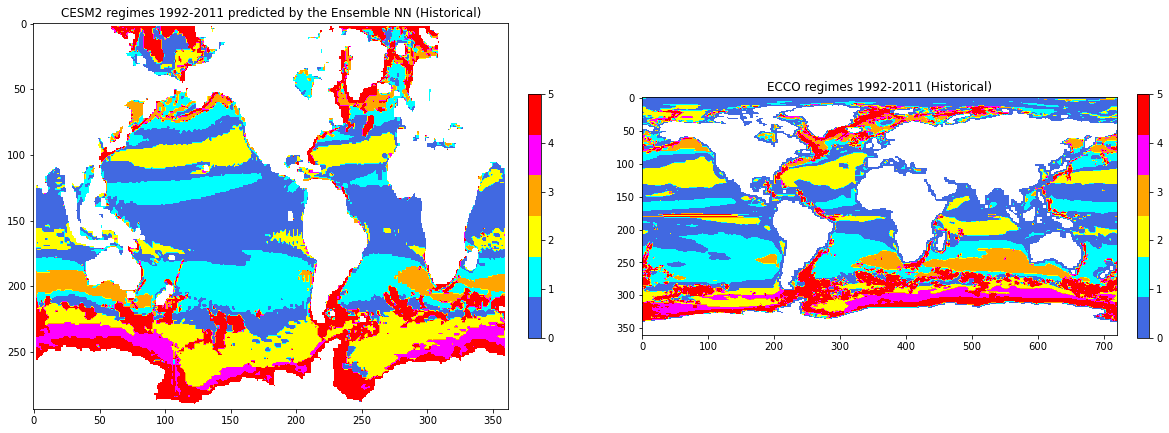

In [194]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(datapredicted_results_Histo[-1,:,:][::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('CESM2 regimes 1992-2011 predicted by the Ensemble NN (Historical)')

plt.subplot(1,2,2)
plt.imshow(ecco_label[::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('ECCO regimes 1992-2011 (Historical)')

# Save the images for the 20 years chunks

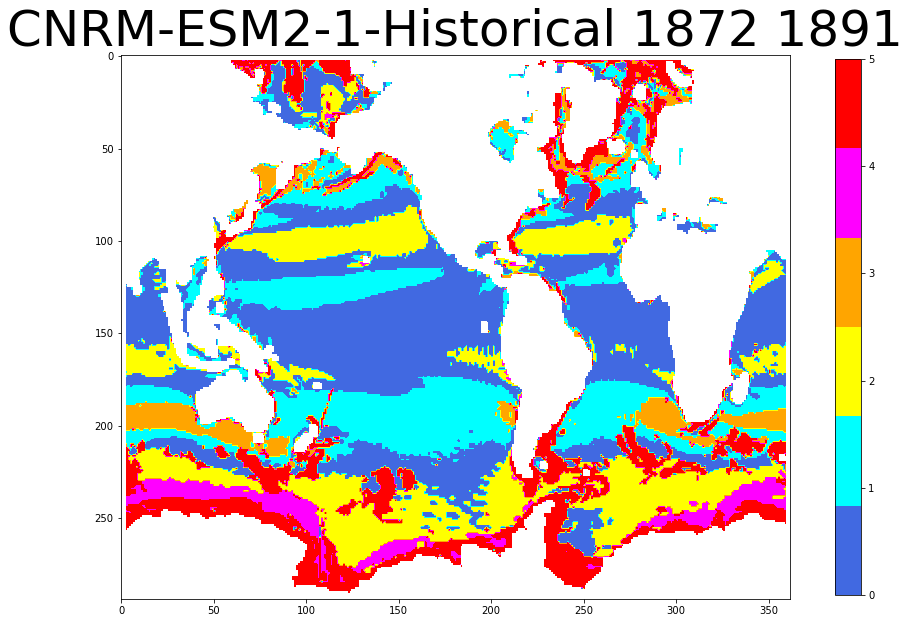

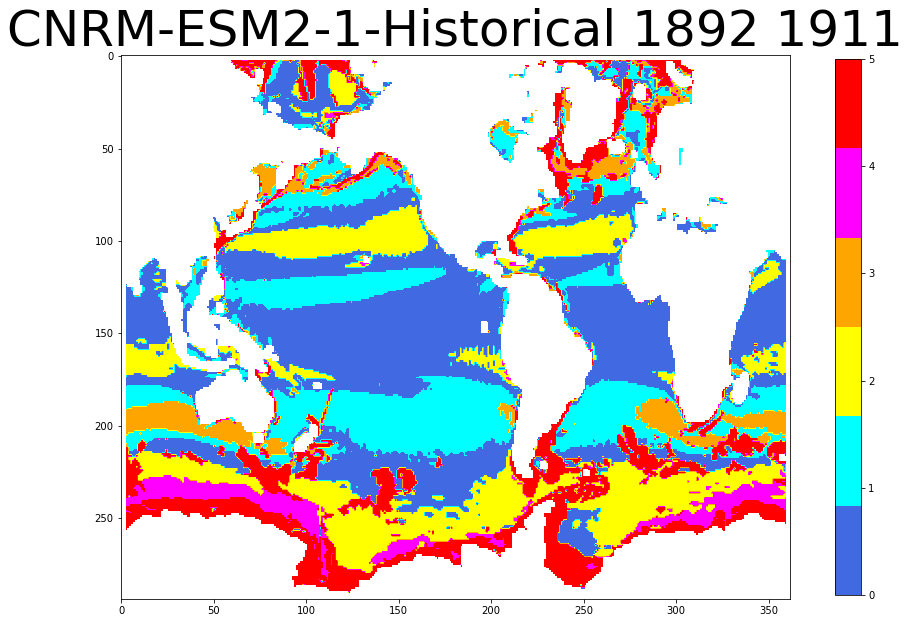

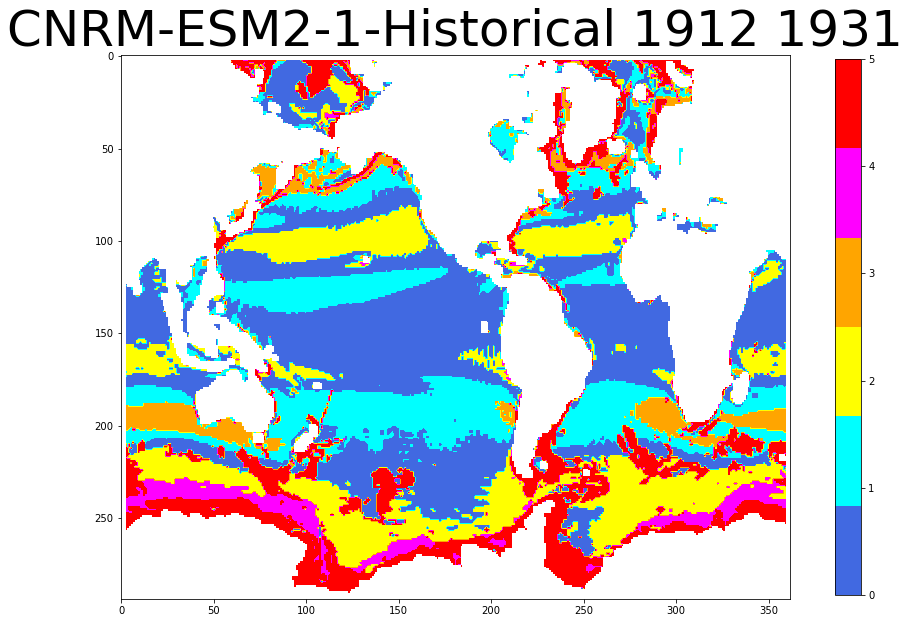

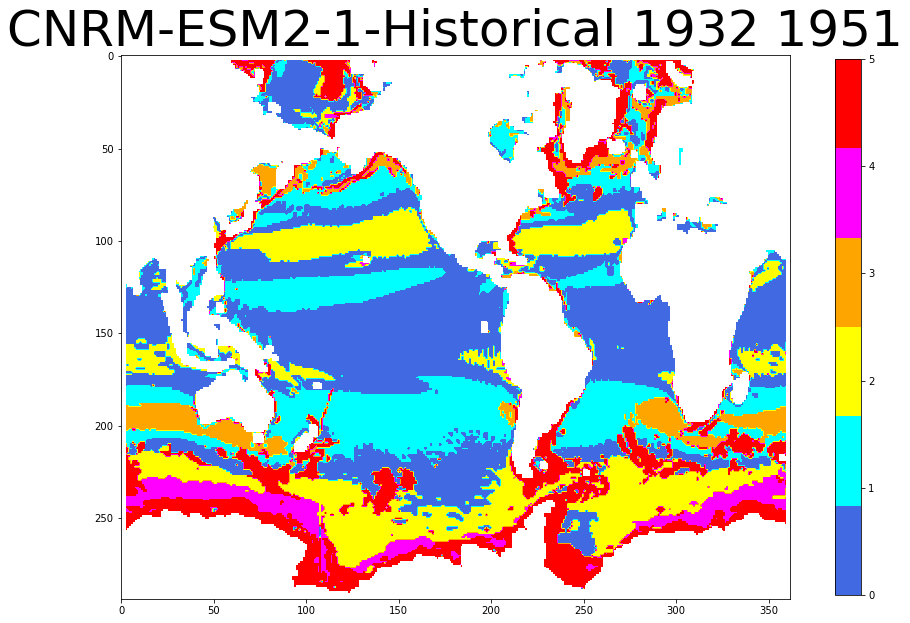

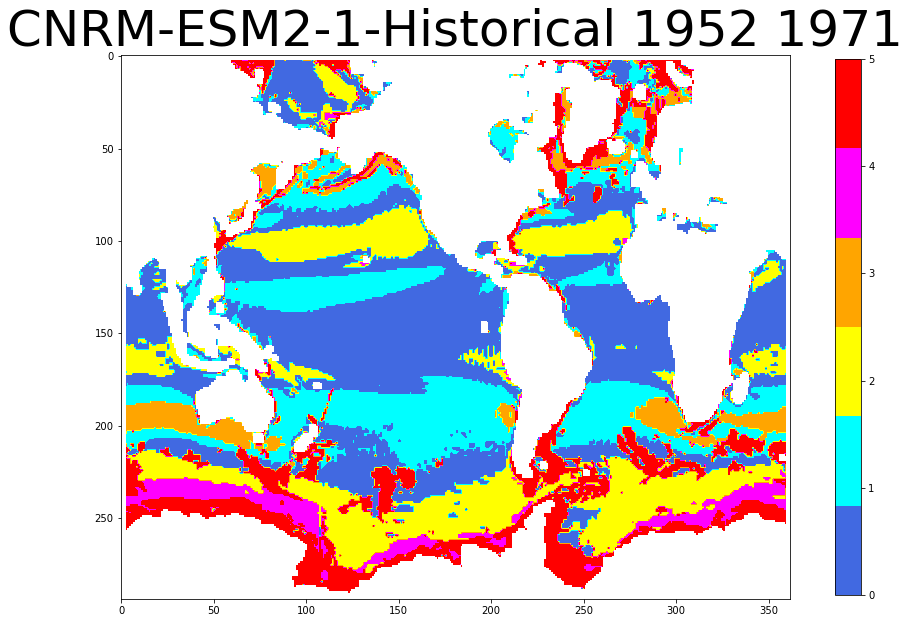

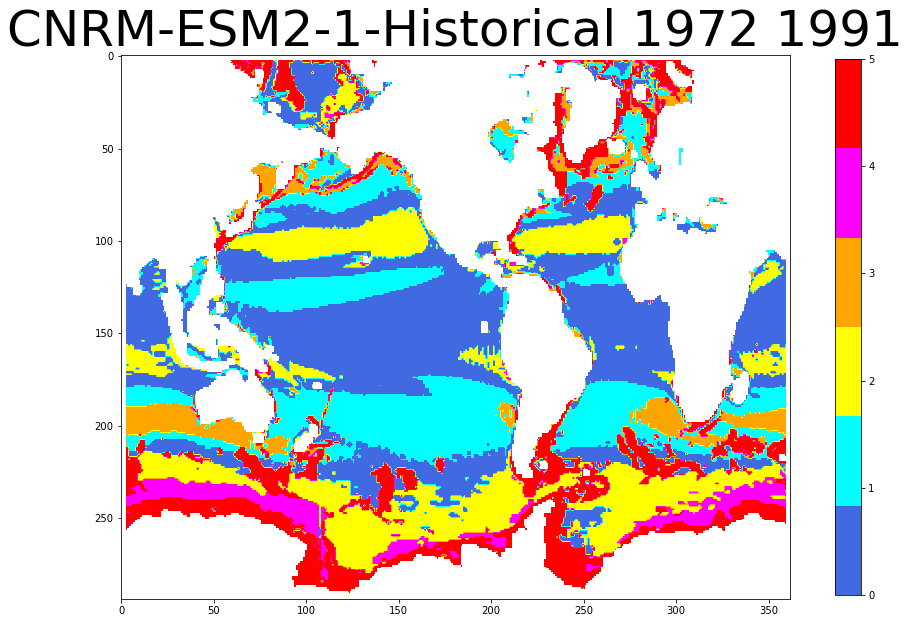

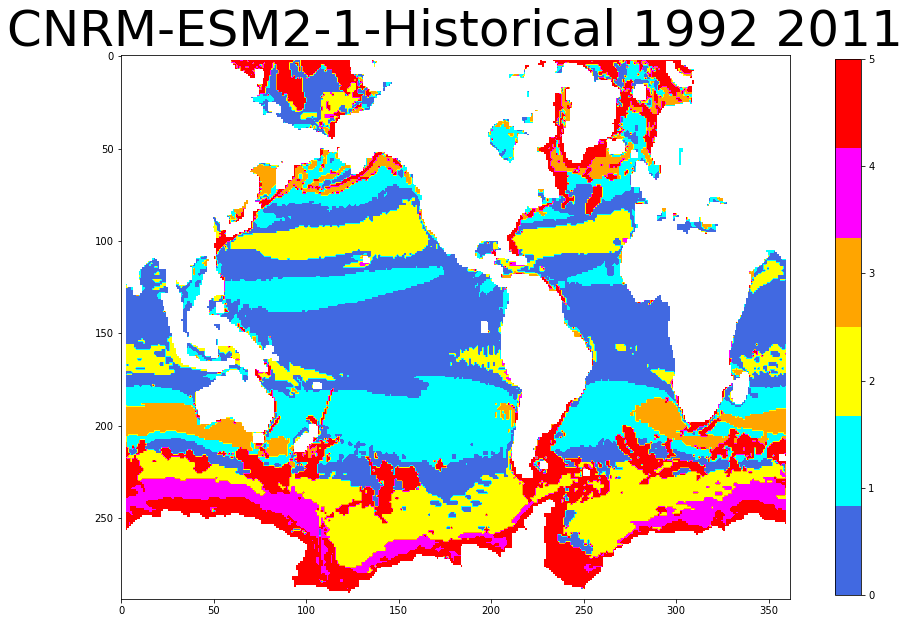

In [195]:
for i in range(7):
    plt.figure(figsize=(20,10))
    #plt.subplot(1,2,1)
    plt.imshow(datapredicted_results_Histo[i,:,:][::-1,:], cmap=mycmap)
    plt.colorbar(fraction=0.024, pad=0.04)
    plt.title('CNRM-ESM2-1-Historical '+str(listyears[2*i])+' '+str(listyears[2*i+1]), fontsize=50)
    plt.savefig('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CNRM-ESM2-1/png_historical_CNRM-ESM2-1/'+str(listyears[2*i])+str(listyears[2*i+1])+'.png')

## create a gif

In [196]:
import os
import imageio

png_dir = 'png_historical_CNRM-ESM2-1/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CNRM-ESM2-1/png_historical_CNRM-ESM2-1/CESM2-png_Historical.gif', images, fps=1)

## Running CNRM-ESM2-1 1%xCO2

## Making some  plots

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


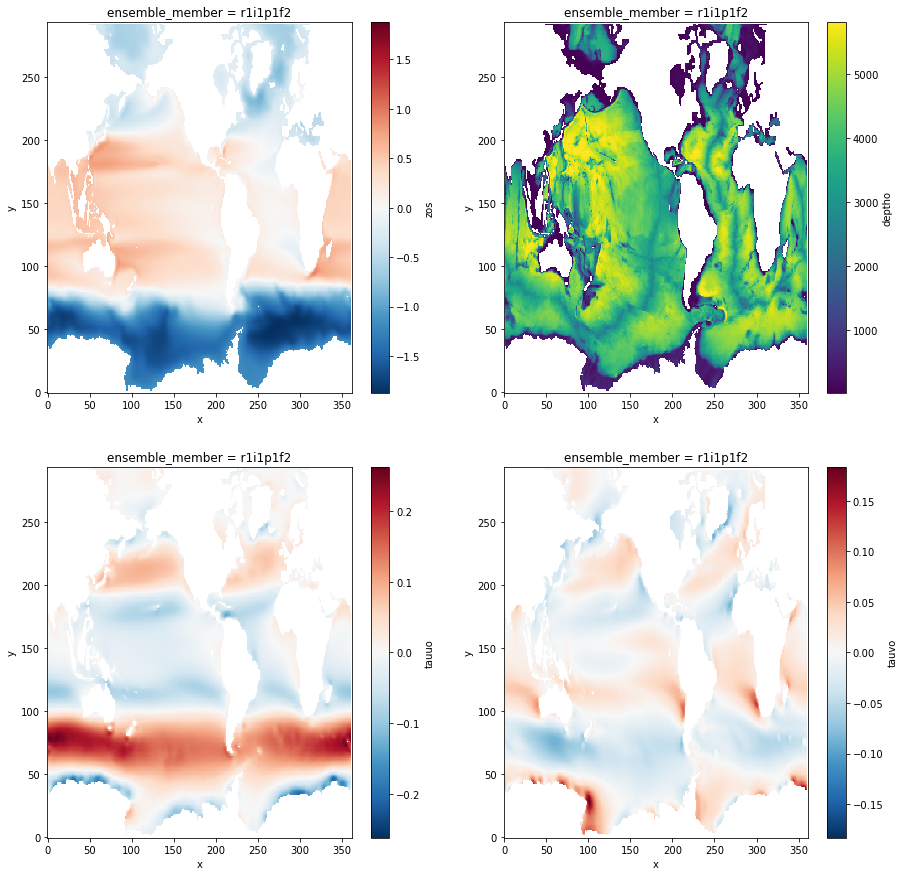

In [197]:
#sel(time=slice("1992", "2011")) I removed the date slice because it was gving me an empty plot. This is specific to 1prctCO2
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
xr_zos_1prctCO2.zos.sel(time=slice("1980", "1999")).mean(axis=1).plot()

plt.subplot(2,2,2)
xr_Ofx_abrupt4pctCO2.deptho[0,:,:,:].max(axis=0).plot()

plt.subplot(2,2,3)
xr_tauuo_1prctCO2.tauuo.sel(time=slice("1980", "1999")).mean(axis=1).plot()

plt.subplot(2,2,4)
xr_tauvo_1prctCO2.tauvo.sel(time=slice("1980", "1999")).mean(axis=1).plot()

In [198]:
xr_zos_1prctCO2.zos.sel(time=slice("1980", "1999")).mean(axis=1)

<xarray.DataArray 'zos' (ensemble_member: 1, y: 294, x: 362)>
dask.array<mean_agg-aggregate, shape=(1, 294, 362), dtype=float32, chunksize=(1, 294, 362), chunktype=numpy.ndarray>
Coordinates:
    lat              (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon              (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f2'
Dimensions without coordinates: y, x

In [199]:
xr_zos_1prctCO2.zos.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
1999-08-16 12:00:00,1999-08-16 12:00:00
1999-09-16 00:00:00,1999-09-16 00:00:00
1999-10-16 12:00:00,1999-10-16 12:00:00


## Predicting CNRM-ESM2-1 1prctCO2...

In [200]:
listyears1prct = ["1860","1879","1880","1899","1900","1919","1920","1939","1940","1959","1960","1979","1980","1999"]

In [201]:
datapredicted_results_1prctCO2 = np.nan * np.zeros((7,)+Ofx.shape)

for i in range(7):
    
    print(listyears1prct[2*i]+listyears1prct[2*i+1])
    SSH20Mean = xr_zos_1prctCO2.zos.isel(ensemble_member=0).sel(time=slice(listyears1prct[2*i], listyears1prct[2*i+1])).mean(axis=0).values
    TauUOMean = xr_tauuo_1prctCO2.tauuo.isel(ensemble_member=0).sel(time=slice(listyears1prct[2*i], listyears1prct[2*i+1])).mean(axis=0).values
    TauVOMean = xr_tauvo_1prctCO2.tauvo.isel(ensemble_member=0).sel(time=slice(listyears1prct[2*i], listyears1prct[2*i+1])).mean(axis=0).values

    ####
    print('Calculate grads')
    gradSSH_y, gradSSH_x = grad(SSH20Mean,latY,lonX)
    gradOfx_y, gradOfx_x = grad(Ofx,latY,lonX)
    gradUx_y, gradUx_x = grad(TauUOMean,latY,lonX)
    gradUy_y, gradUy_x = grad(TauVOMean,latY,lonX)
    ####
    print('Calculate CurlTau')
    curlTau =(gradUy_x-gradUx_y)/1032
    
    ####
    print('Calculate missindx')
    missingdataindex = np.isnan(curlTau*SSH20Mean*
                                   gradSSH_x*gradSSH_y*
                                   Ofx*gradOfx_x*
                                   gradOfx_y*f)
    ####
    print('Creating TotalDataset')
    TotalDataset = np.stack((curlTau[~missingdataindex],
                         SSH20Mean[~missingdataindex],
                         gradSSH_x[~missingdataindex],
                         gradSSH_y[~missingdataindex],
                         Ofx.values[~missingdataindex],
                         gradOfx_x[~missingdataindex],
                         gradOfx_y[~missingdataindex],
                         f[~missingdataindex]),1)
    ####
    print('NN pred')
    
    datapredicted_results_vanilla_ensemble = np.nan * np.zeros((50,TotalDataset.shape[0],6))

    for j in range(50):
        I1 = Input(shape=(8,)) 
        h1 = Dense(24, activation='tanh')(I1)
        h1 = Dense(24, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        Output = Dense(6, activation='softmax')(h1)
        vanillamodel = Model(I1, Output)
        vanillamodel.load_weights(wgtsdir+'/vanillamodel_'+str(j)+'.h5') ###path in github repo
        datapredicted = vanillamodel.predict(scaler.transform(TotalDataset))#a1r
        datapredicted_results_vanilla_ensemble[j,...] = datapredicted
        
    tmpMean = np.mean(datapredicted_results_vanilla_ensemble,0)
    tmpSoftmax = special.softmax(tmpMean,1)
    datapredicted_results_1prctCO2[i,:,:][~missingdataindex] = np.argmax(tmpSoftmax, 1)

    
np.save('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CNRM-ESM2-1/CNRM-ESM2-1-1prctCO2-198701-201112-EnsembleMLP.npy',datapredicted_results_1prctCO2)
    

18601879


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


18801899


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19001919


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19201939


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19401959


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19601979


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19801999


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate grads
Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'ECCO regimes 0131-0150 (1prctCO2)')

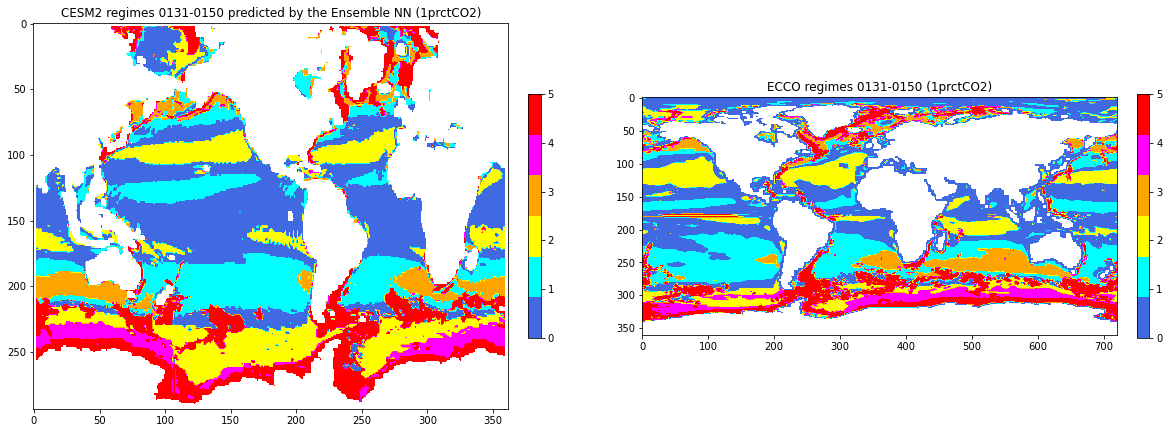

In [202]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(datapredicted_results_1prctCO2[-1,:,:][::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('CESM2 regimes 0131-0150 predicted by the Ensemble NN (1prctCO2)')

plt.subplot(1,2,2)
plt.imshow(ecco_label[::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('ECCO regimes 0131-0150 (1prctCO2)')

# Save the images for the 20 years chunks

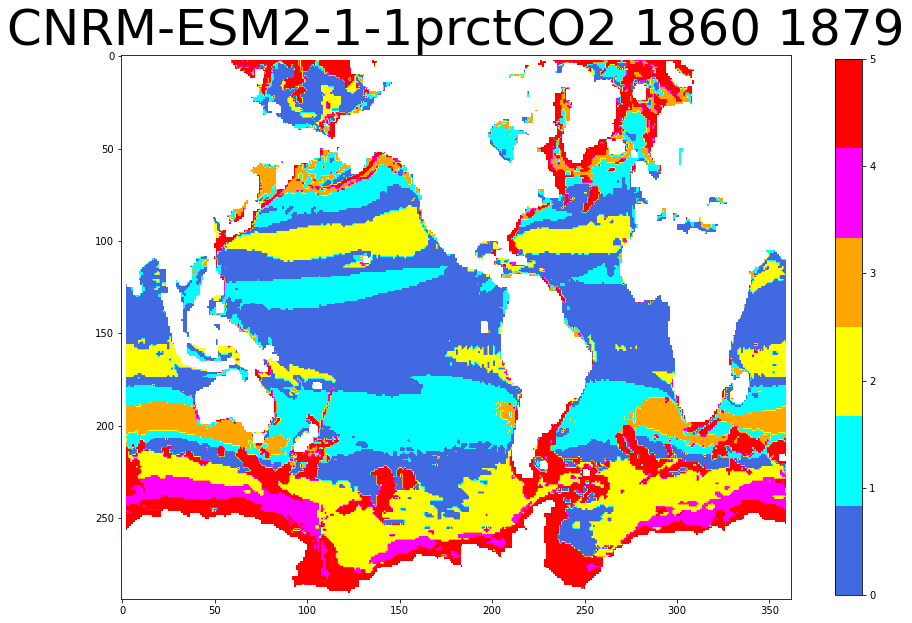

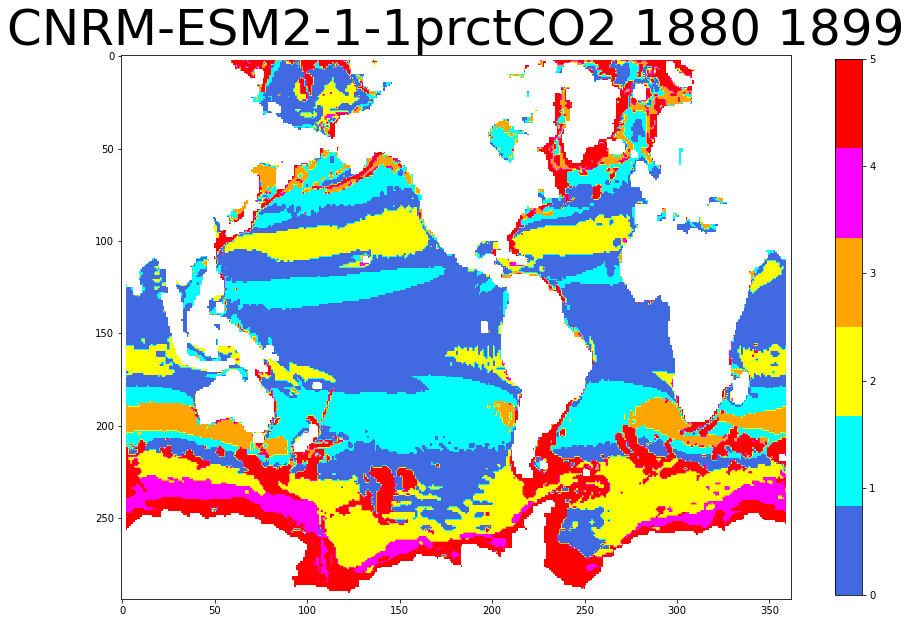

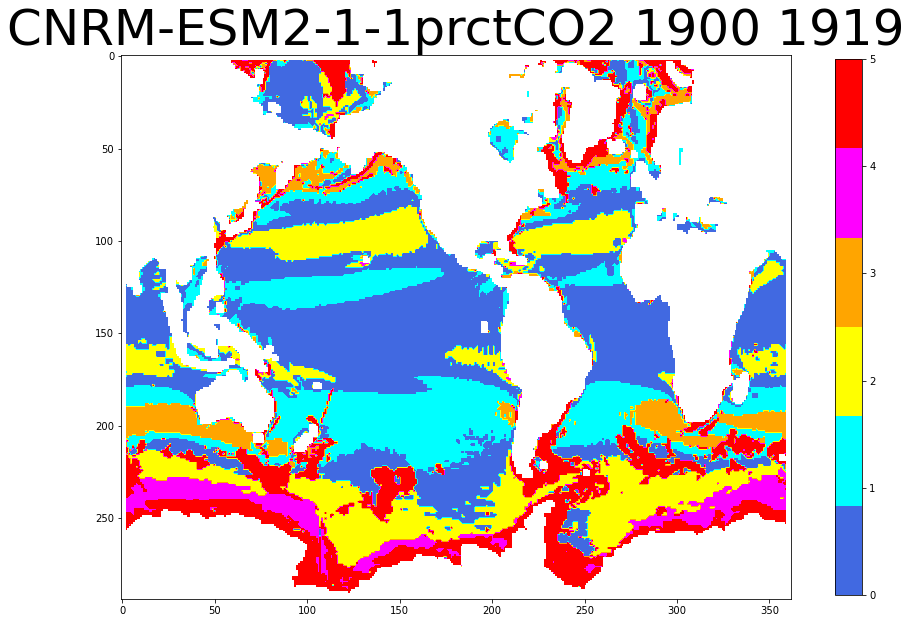

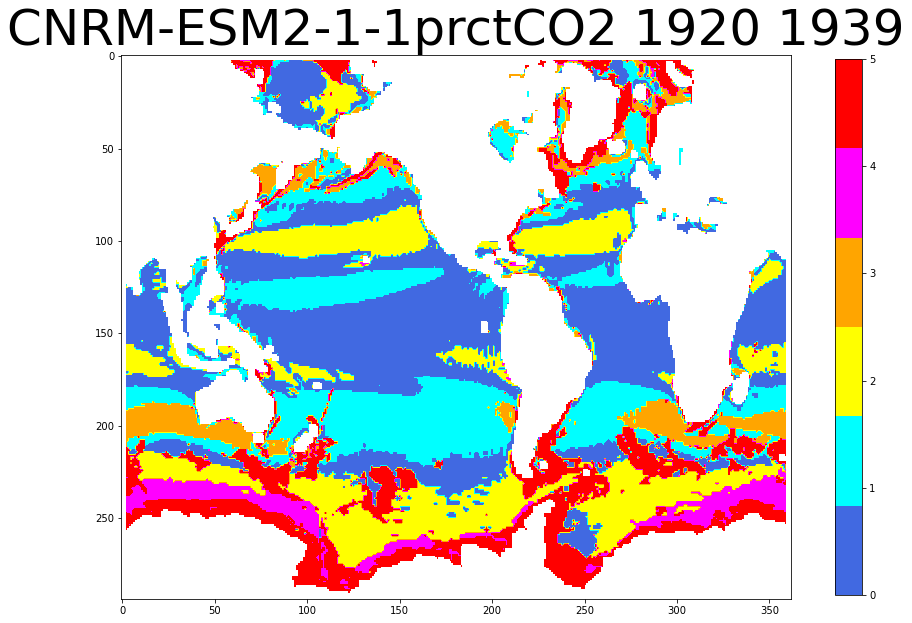

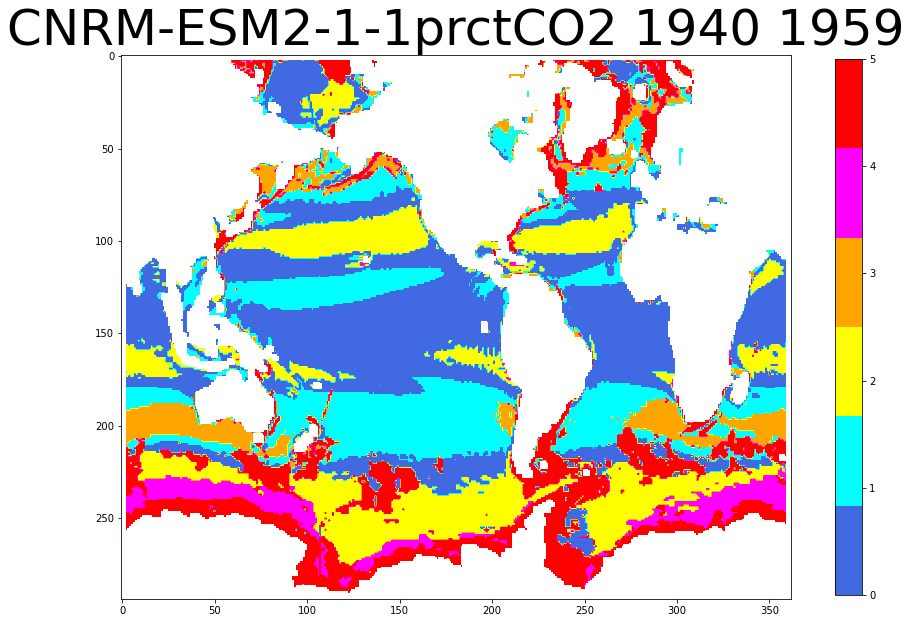

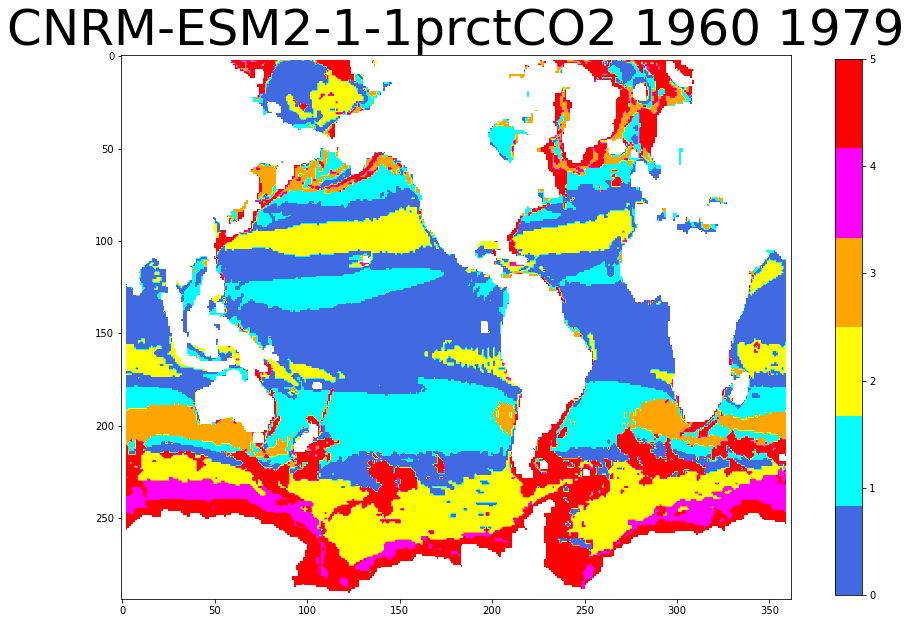

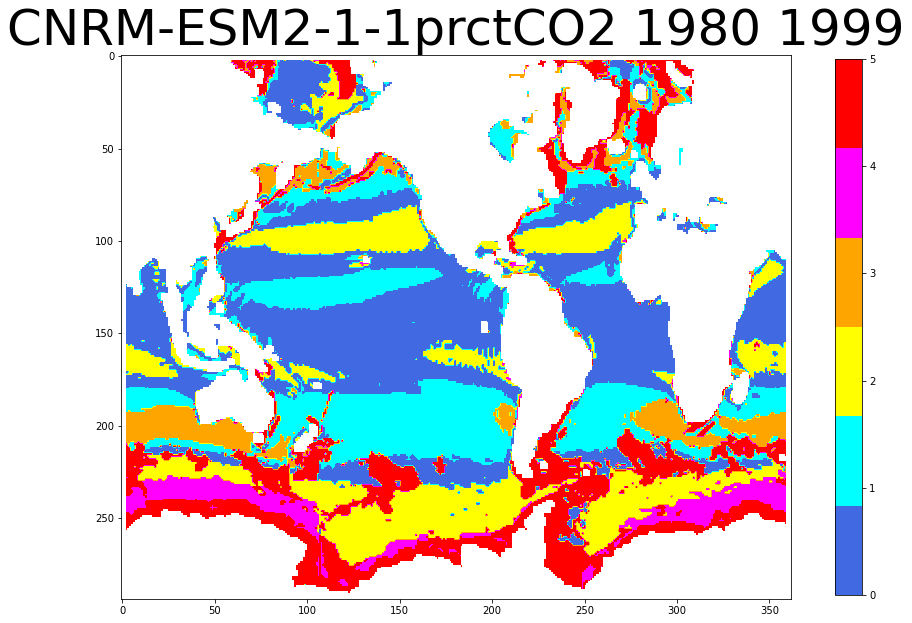

In [203]:
for i in range(7):
    plt.figure(figsize=(20,10))
    #plt.subplot(1,2,1)
    plt.imshow(datapredicted_results_1prctCO2[i,:,:][::-1,:], cmap=mycmap)
    plt.colorbar(fraction=0.024, pad=0.04)
    plt.title('CNRM-ESM2-1-1prctCO2 '+str(listyears1prct[2*i])+' '+str(listyears1prct[2*i+1]), fontsize=50)
    plt.savefig('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CNRM-ESM2-1/png_1prctCO2_CNRM-ESM2-1/'+str(listyears[2*i])+str(listyears[2*i+1])+'.png')

## create a gif

In [205]:
import os
import imageio

png_dir = 'png_1prctCO2_CNRM-ESM2-1/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('png_1prctCO2_CNRM-ESM2-1/CNRM-ESM2-1-png_1prctCO2.gif', images, fps=1)

## Running abrupt4xCO2

In [206]:
xr_zos_abrupt4prctCO2.zos.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
1999-08-16 12:00:00,1999-08-16 12:00:00
1999-09-16 00:00:00,1999-09-16 00:00:00
1999-10-16 12:00:00,1999-10-16 12:00:00


## Making some plots

In [207]:
xr_zos_1prctCO2.zos.sel(time=slice("1992", "2011")).mean(axis=1)

<xarray.DataArray 'zos' (ensemble_member: 1, y: 294, x: 362)>
dask.array<mean_agg-aggregate, shape=(1, 294, 362), dtype=float32, chunksize=(1, 294, 362), chunktype=numpy.ndarray>
Coordinates:
    lat              (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon              (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f2'
Dimensions without coordinates: y, x

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


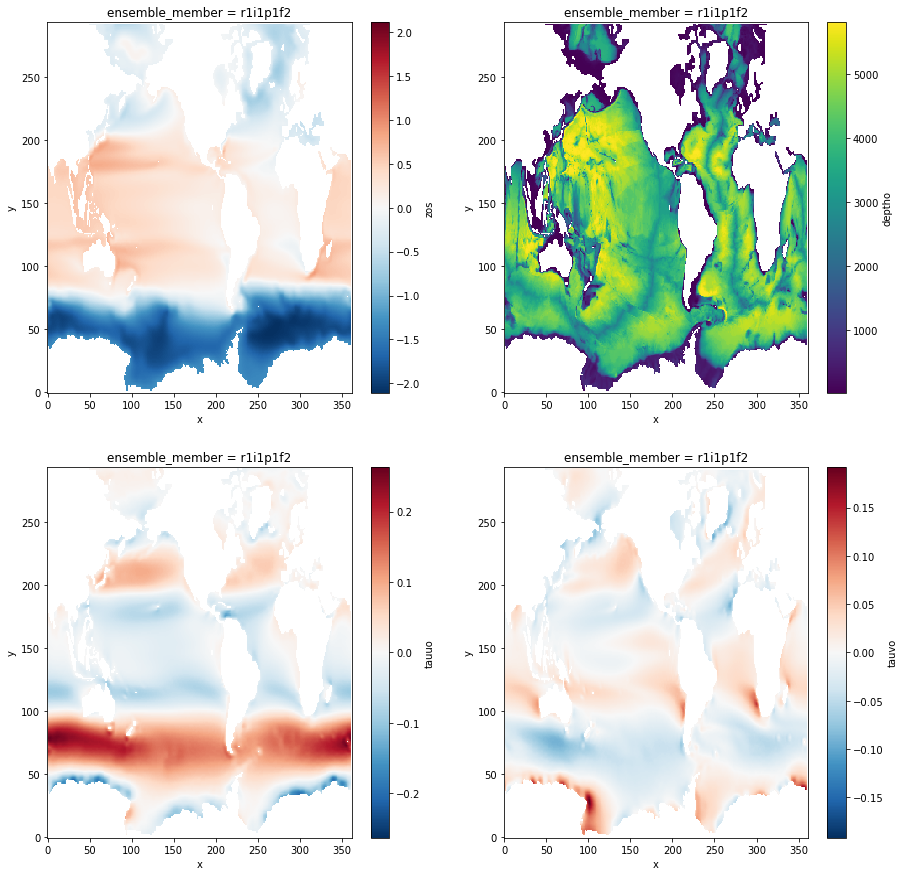

In [208]:
#sel(time=slice("1992", "2011")) I removed the date slice because it was gving me an empty plot. This is specific to 1prctCO2
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
xr_zos_abrupt4prctCO2.zos.sel(time=slice("1980","1999")).mean(axis=1).plot()

plt.subplot(2,2,2)
xr_Ofx_abrupt4pctCO2.deptho[0,:,:,:].max(axis=0).plot()

plt.subplot(2,2,3)
xr_tauuo_abrupt4prctCO2.tauuo.sel(time=slice("1980","1999")).mean(axis=1).plot()

plt.subplot(2,2,4)
xr_tauvo_abrupt4prctCO2.tauvo.sel(time=slice("1980","1999")).mean(axis=1).plot()

## Predicting abrupt-4xCO2...

In [209]:
listyears4abruptprct = ["1860","1879","1880","1899","1900","1919","1920","1939","1940","1959","1960","1979","1980","1999"]

In [210]:
datapredicted_results_abrupt4CO2 = np.nan * np.zeros((7,)+Ofx.shape)

for i in range(7):
    
    print(listyears1prct[2*i]+listyears1prct[2*i+1])
    SSH20Mean = xr_zos_abrupt4prctCO2.zos.isel(ensemble_member=0).sel(time=slice(listyears4abruptprct[2*i], listyears4abruptprct[2*i+1])).mean(axis=0).values
    TauUOMean = xr_tauuo_abrupt4prctCO2.tauuo.isel(ensemble_member=0).sel(time=slice(listyears4abruptprct[2*i], listyears4abruptprct[2*i+1])).mean(axis=0).values
    TauVOMean = xr_tauvo_abrupt4prctCO2.tauvo.isel(ensemble_member=0).sel(time=slice(listyears4abruptprct[2*i], listyears4abruptprct[2*i+1])).mean(axis=0).values

    ####
    print('Calculate grads')
    gradSSH_y, gradSSH_x = grad(SSH20Mean,latY,lonX)
    gradOfx_y, gradOfx_x = grad(Ofx,latY,lonX)
    gradUx_y, gradUx_x = grad(TauUOMean,latY,lonX)
    gradUy_y, gradUy_x = grad(TauVOMean,latY,lonX)
    ####
    print('Calculate CurlTau')
    curlTau =(gradUy_x-gradUx_y)/1032
    
    ####
    print('Calculate missindx')
    missingdataindex = np.isnan(curlTau*SSH20Mean*
                                   gradSSH_x*gradSSH_y*
                                   Ofx*gradOfx_x*
                                   gradOfx_y*f)
    ####
    print('Creating TotalDataset')
    TotalDataset = np.stack((curlTau[~missingdataindex],
                         SSH20Mean[~missingdataindex],
                         gradSSH_x[~missingdataindex],
                         gradSSH_y[~missingdataindex],
                         Ofx.values[~missingdataindex],
                         gradOfx_x[~missingdataindex],
                         gradOfx_y[~missingdataindex],
                         f[~missingdataindex]),1)
    ####
    print('NN pred')
    
    datapredicted_results_vanilla_ensemble = np.nan * np.zeros((50,TotalDataset.shape[0],6))

    for j in range(50):
        I1 = Input(shape=(8,)) 
        h1 = Dense(24, activation='tanh')(I1)
        h1 = Dense(24, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        Output = Dense(6, activation='softmax')(h1)
        vanillamodel = Model(I1, Output)
        vanillamodel.load_weights(wgtsdir+'/vanillamodel_'+str(j)+'.h5') ###path in github repo
        datapredicted = vanillamodel.predict(scaler.transform(TotalDataset))#a1r
        datapredicted_results_vanilla_ensemble[j,...] = datapredicted
        
    tmpMean = np.mean(datapredicted_results_vanilla_ensemble,0)
    tmpSoftmax = special.softmax(tmpMean,1)
    datapredicted_results_abrupt4CO2[i,:,:][~missingdataindex] = np.argmax(tmpSoftmax, 1)

    
np.save('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CNRM-ESM2-1/CNRM-ESM2-1-abrupt4CO2-198701-201112-EnsembleMLP.npy',datapredicted_results_abrupt4CO2)
    

18601879


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


18801899


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19001919


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19201939


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19401959


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19601979


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19801999


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'ECCO regimes 0131-0150 (abrupt4CO2)')

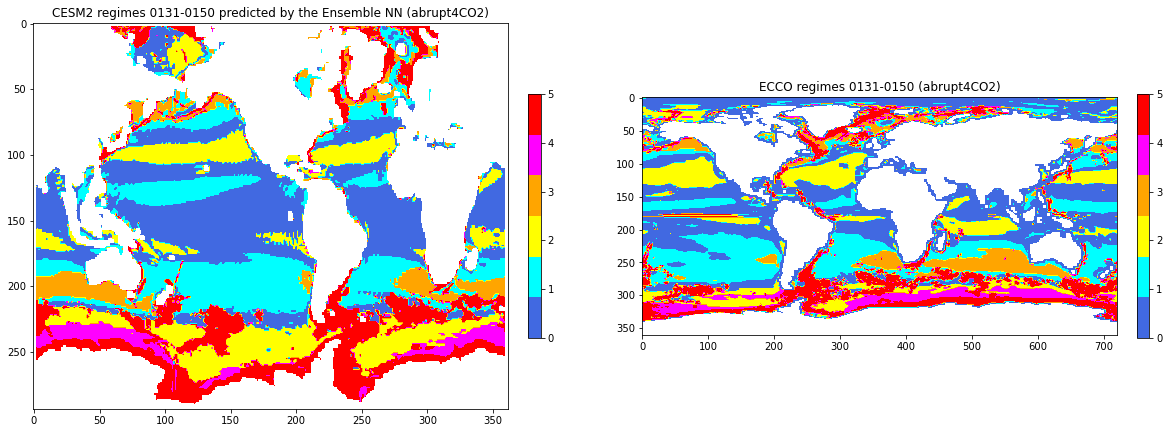

In [211]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(datapredicted_results_abrupt4CO2[-1,:,:][::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('CESM2 regimes 0131-0150 predicted by the Ensemble NN (abrupt4CO2)')

plt.subplot(1,2,2)
plt.imshow(ecco_label[::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('ECCO regimes 0131-0150 (abrupt4CO2)')

# Save the images for the 20 years chunks

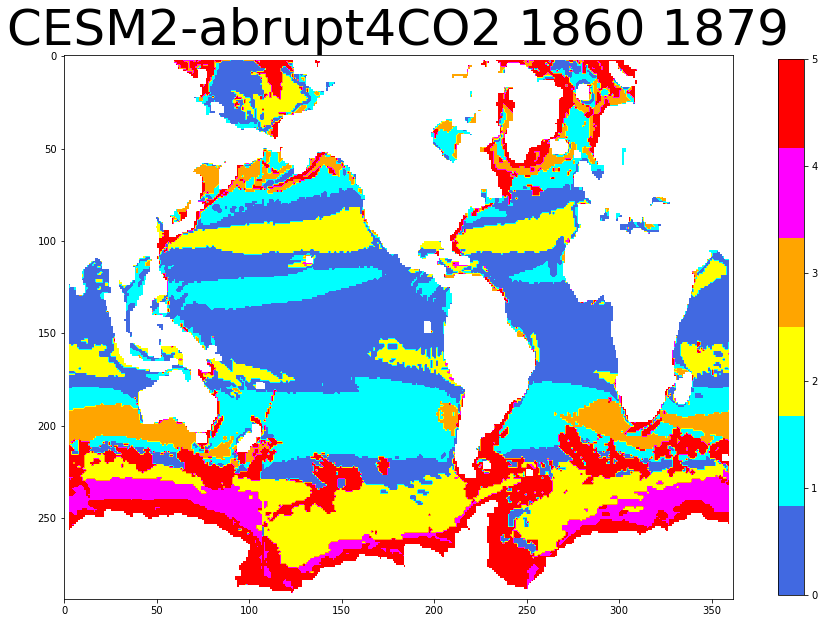

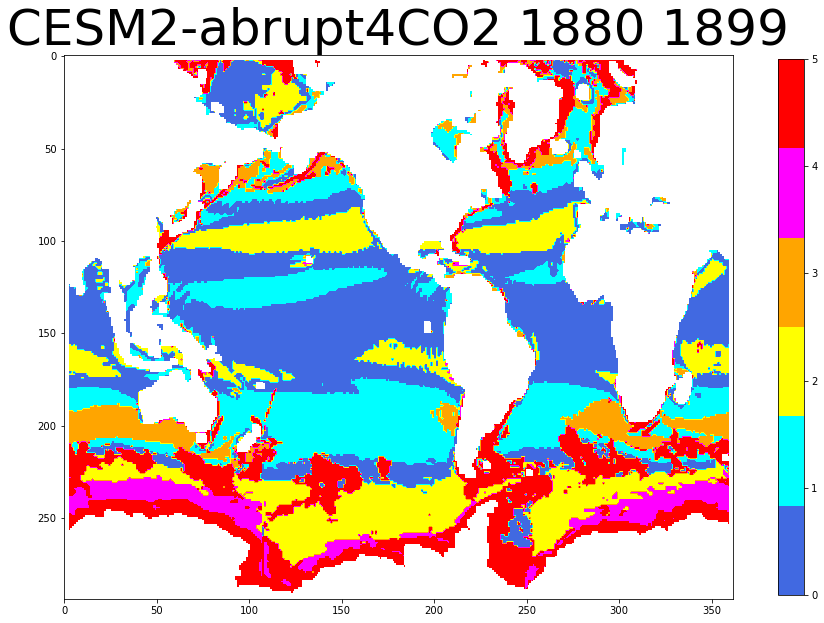

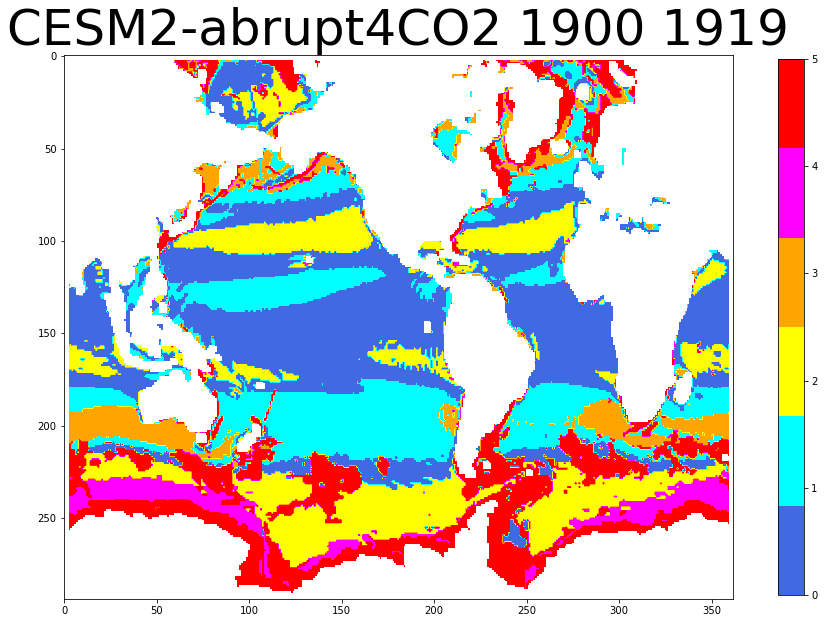

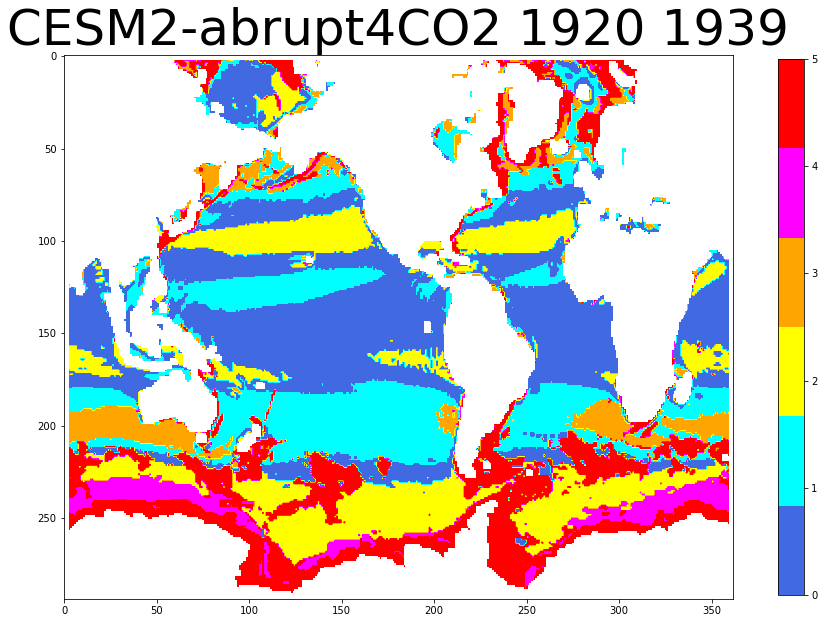

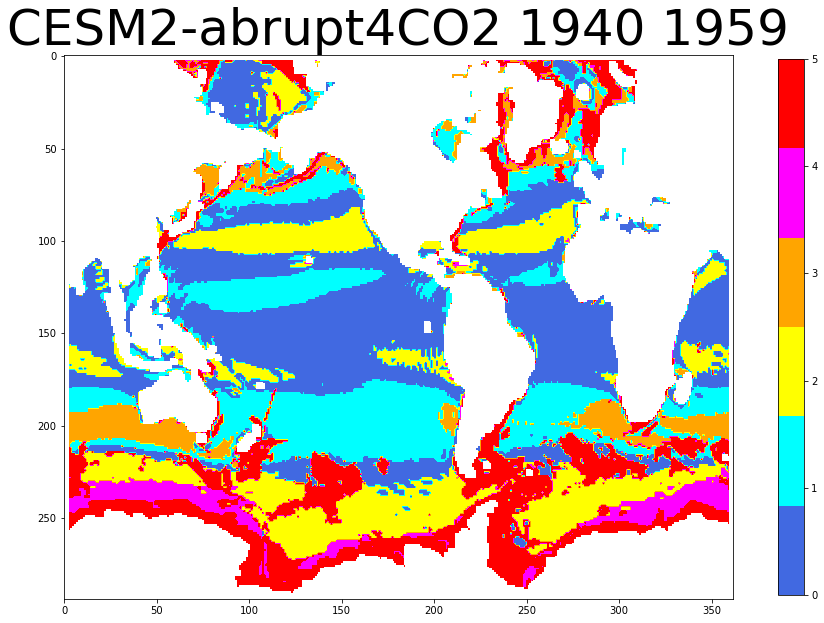

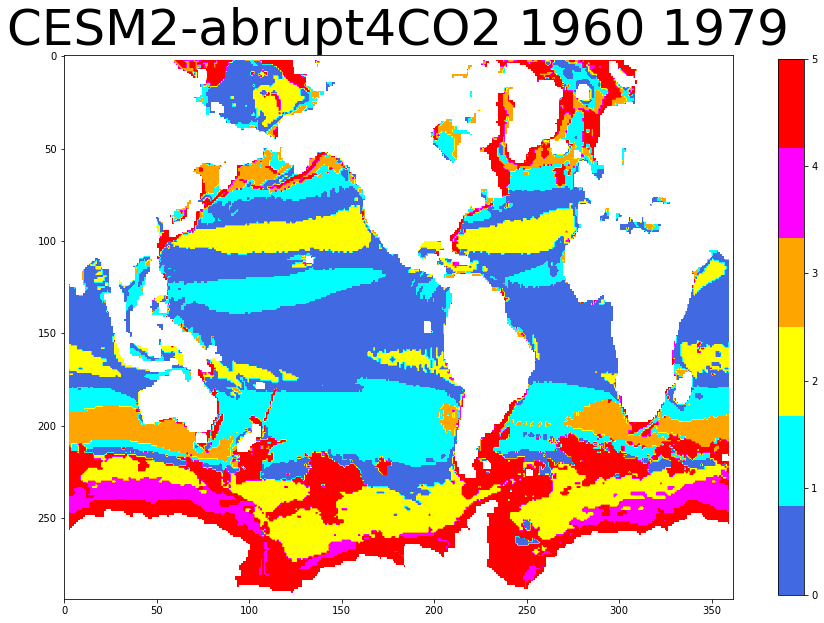

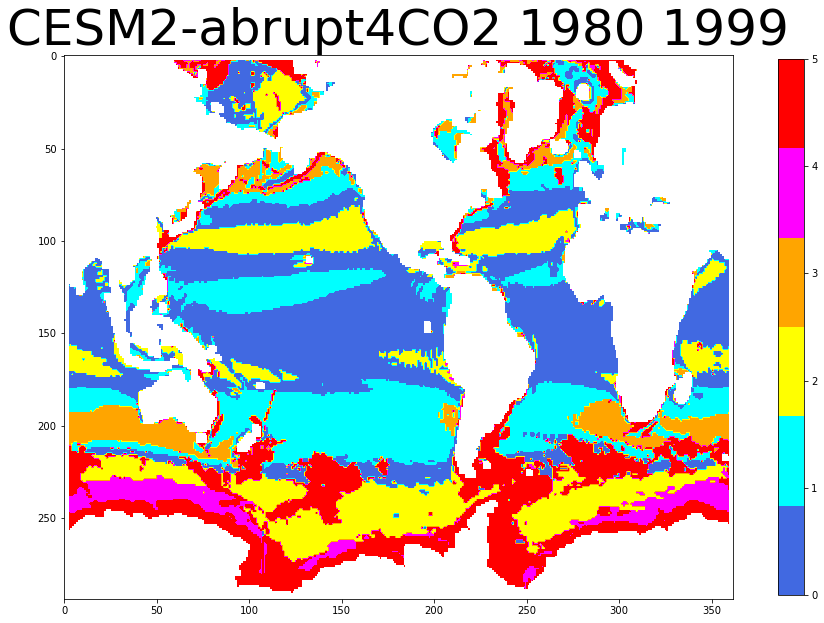

In [212]:
for i in range(7):
    plt.figure(figsize=(20,10))
    #plt.subplot(1,2,1)
    plt.imshow(datapredicted_results_abrupt4CO2[i,:,:][::-1,:], cmap=mycmap)
    plt.colorbar(fraction=0.024, pad=0.04)
    plt.title('CESM2-abrupt4CO2 '+str(listyears4abruptprct[2*i])+' '+str(listyears4abruptprct[2*i+1]), fontsize=50)
    plt.savefig('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/CNRM-ESM2-1/png_abrupt4prctCO2_CNRM-ESM2-1/'+str(listyears4abruptprct[2*i])+str(listyears4abruptprct[2*i+1])+'.png')

## create a gif

In [213]:
import os
import imageio

png_dir = 'png_abrupt4prctCO2_CNRM-ESM2-1/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('png_abrupt4prctCO2_CNRM-ESM2-1/png_abrupt4prctCO2_CNRM-ESM2-1.gif', images, fps=1)